In [21]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from konlpy.tag import Komoran
from sklearn.feature_extraction.text import TfidfVectorizer

# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [2]:
tokenizer = Komoran()

def read_token(file_name, desc=None, position=0):
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: # 파일 사이즈를 기준으로 진행바 그리기
        # 파일 처리 진행도를 그리는 진행바
        pbar = tqdm(total=os.path.getsize(os.getenv('HOME')+'/aiffel/weat/'+file_name), 
                    desc=desc, 
                    position=position)
        
        while True:
            line = fread.readline() 
            if not line: break 
            # 문장에서 명사만 추출
            result.extend(tokenizer.nouns(line))
                    
            # 불러온 바이트 크기만큼 진행바 업데이트
            pbar.update(len(line.encode('utf-8')))
        # 진행바 완료 처리
        pbar.close()

    return ' '.join(result)

In [3]:
# corpus 파일
synopsis_text = 'synopsis.txt'

# target 파일
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

# attribute 파일 리스트
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [4]:
# corpus 가져오기
corpus = []
with open(os.getenv('HOME')+'/aiffel/weat/'+synopsis_text, 'r') as fread: # 파일 사이즈를 기준으로 진행바 그리기
    # 파일 처리 진행도를 그리는 진행바
    pbar = tqdm(total=os.path.getsize(os.getenv('HOME')+'/aiffel/weat/'+synopsis_text), 
                desc='corpus')

    while True:
        line = fread.readline() 
        if not line: break 
        # 문장에서 명사만 추출
        corpus.append(tokenizer.nouns(line))

        # 불러온 바이트 크기만큼 진행바 업데이트
        pbar.update(len(line.encode('utf-8')))
    # 진행바 완료 처리
    pbar.close()

corpus:   0%|          | 0/17752952 [00:00<?, ?it/s]

In [5]:
# 명사 추출이 되는지 확인
print(len(corpus))
print(corpus[0])

71156
['사운드', '엔지니어', '상', '우', '유지태', '분', '치매', '할머니', '백성희', '분']


In [6]:
# target 말뭉치 가져오기
art = read_token(art_txt, 'art')
gen = read_token(gen_txt, 'gen')

art:   0%|          | 0/2737865 [00:00<?, ?it/s]

gen:   0%|          | 0/13398320 [00:00<?, ?it/s]

In [7]:
# attribute 말뭉치 가져오기
genre = []
for genre_path, name in tqdm(zip(genre_txt, genre_name), 
                             total=len(genre_name),
                             desc='genre'):
    genre.append(read_token(genre_path, desc=name, position=1))

genre:   0%|          | 0/21 [00:00<?, ?it/s]

SF:   0%|          | 0/276105 [00:00<?, ?it/s]

가족:   0%|          | 0/106163 [00:00<?, ?it/s]

공연:   0%|          | 0/101338 [00:00<?, ?it/s]

공포(호러):   0%|          | 0/761520 [00:00<?, ?it/s]

기타:   0%|          | 0/636890 [00:00<?, ?it/s]

다큐멘터리:   0%|          | 0/2017337 [00:00<?, ?it/s]

드라마:   0%|          | 0/5151492 [00:00<?, ?it/s]

멜로로맨스:   0%|          | 0/1356092 [00:00<?, ?it/s]

뮤지컬:   0%|          | 0/44068 [00:00<?, ?it/s]

미스터리:   0%|          | 0/204375 [00:00<?, ?it/s]

범죄:   0%|          | 0/371729 [00:00<?, ?it/s]

사극:   0%|          | 0/45299 [00:00<?, ?it/s]

서부극(웨스턴):   0%|          | 0/11749 [00:00<?, ?it/s]

성인물(에로):   0%|          | 0/606086 [00:00<?, ?it/s]

스릴러:   0%|          | 0/558890 [00:00<?, ?it/s]

애니메이션:   0%|          | 0/1638647 [00:00<?, ?it/s]

액션:   0%|          | 0/1454329 [00:00<?, ?it/s]

어드벤처:   0%|          | 0/125859 [00:00<?, ?it/s]

전쟁:   0%|          | 0/106944 [00:00<?, ?it/s]

코미디:   0%|          | 0/1394921 [00:00<?, ?it/s]

판타지:   0%|          | 0/159187 [00:00<?, ?it/s]

# STEP 2. 추출된 결과로 embedding model 만들기

In [8]:
model = Word2Vec(sentences=corpus,
                 vector_size=3000,
                 window=5,
                 min_count=5,
                 workers=4,
                 sg=1)

In [9]:
model.wv.most_similar('남자')

[('여자', 0.7285671234130859),
 ('그 여자', 0.7149316668510437),
 ('사내', 0.6895236372947693),
 ('남자들', 0.6736619472503662),
 ('종두', 0.6718348860740662),
 ('두 여자', 0.6543571949005127),
 ('밤거리', 0.6454757452011108),
 ('동거녀', 0.6396735906600952),
 ('아는 여자', 0.6389144659042358),
 ('허물', 0.6363397240638733)]

In [10]:
model.wv.most_similar('여자')

[('그 여자', 0.7318713665008545),
 ('남자', 0.7285671234130859),
 ('종두', 0.6665416955947876),
 ('남자들', 0.6408053636550903),
 ('두기', 0.6393619775772095),
 ('스토킹', 0.6381886005401611),
 ('허물', 0.6354616284370422),
 ('아는 여자', 0.6352965831756592),
 ('후안', 0.6343703269958496),
 ('바텐더', 0.6341785192489624)]

In [11]:
model.wv.most_similar('영화')

[('영화로', 0.7306223511695862),
 ('다큐멘터리', 0.7164408564567566),
 ('옴니버스', 0.7030378580093384),
 ('전작', 0.6918044686317444),
 ('편의', 0.6892226338386536),
 ('서사', 0.686048686504364),
 ('픽션', 0.6829968094825745),
 ('드라마', 0.6818315982818604),
 ('설정', 0.6811093688011169),
 ('차용', 0.6781631708145142)]

In [12]:
model.wv.most_similar('감독')

[('신작', 0.7059822082519531),
 ('데뷔작', 0.6977284550666809),
 ('영화감독', 0.69254469871521),
 ('거장', 0.6859962940216064),
 ('장편', 0.6635642051696777),
 ('키아로스타미', 0.6571603417396545),
 ('영화 제작', 0.6563647389411926),
 ('영화로', 0.6505518555641174),
 ('뤽', 0.6464004516601562),
 ('부작', 0.6452431082725525)]

- 남자, 여자
    - 서로가 가장 유사한 단어
    - 그외 겹치는 유사 단어들이 많음
- 영화, 감독
    - 각자 의미상 유사한 단어들이 많이 나옴

# STEP 3. target, attribute 단어 셋 만들기

## target 단어 셋

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [14]:
#TF-IDF를 행렬로 저장
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

# 단어들을 TF-IDF가 높은 순으로 정렬
w1.sort(key=lambda x: x[1], reverse=True)  
w2.sort(key=lambda x: x[1], reverse=True)

In [15]:
n = 15
w1_, w2_ = [], []
# 상위 100개 단어 추출
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
print('예술영화를 대표하는 단어들:')
for w in target_art:
    print(w, end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for w in target_gen:
    print(w, end=', ')

예술영화를 대표하는 단어들:
음악, 여인, 이름, 준비, 충격, 희망, 청년, 연인, 상처, 목숨, 프랑스, 매력, 진실, 모두, 만남, 

일반영화를 대표하는 단어들:
국제, 애니메이션, 서울, 주인공, 연출, 섹스, 다큐멘터리, 부문, 조직, 의도, 회사, 일본, 부부, 문제, 경쟁, 

## attribute 단어 셋 

In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

In [18]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

In [23]:
w_ = list(map(lambda s: sorted(s, key=lambda x: x[1]), w))

In [24]:
genre_voc = []

# 장르별 단어 사전 생성
for i in trange(len(w)):
    voc = []
    for col, _ in tqdm(w_[i], desc=genre_name[i], position=1):
        word = vectorizer.get_feature_names()[col]
        if word in model.wv:
            voc.append(word)
    genre_voc.append(voc)

  0%|          | 0/21 [00:00<?, ?it/s]

SF:   0%|          | 0/4378 [00:00<?, ?it/s]

가족:   0%|          | 0/2237 [00:00<?, ?it/s]

공연:   0%|          | 0/2100 [00:00<?, ?it/s]

공포(호러):   0%|          | 0/7068 [00:00<?, ?it/s]

기타:   0%|          | 0/7496 [00:00<?, ?it/s]

다큐멘터리:   0%|          | 0/14914 [00:00<?, ?it/s]

드라마:   0%|          | 0/21431 [00:00<?, ?it/s]

멜로로맨스:   0%|          | 0/9545 [00:00<?, ?it/s]

뮤지컬:   0%|          | 0/1274 [00:00<?, ?it/s]

미스터리:   0%|          | 0/3501 [00:00<?, ?it/s]

범죄:   0%|          | 0/5559 [00:00<?, ?it/s]

사극:   0%|          | 0/1312 [00:00<?, ?it/s]

서부극(웨스턴):   0%|          | 0/409 [00:00<?, ?it/s]

성인물(에로):   0%|          | 0/4561 [00:00<?, ?it/s]

스릴러:   0%|          | 0/6492 [00:00<?, ?it/s]

애니메이션:   0%|          | 0/11608 [00:00<?, ?it/s]

액션:   0%|          | 0/11723 [00:00<?, ?it/s]

어드벤처:   0%|          | 0/2817 [00:00<?, ?it/s]

전쟁:   0%|          | 0/2460 [00:00<?, ?it/s]

코미디:   0%|          | 0/12399 [00:00<?, ?it/s]

판타지:   0%|          | 0/2882 [00:00<?, ?it/s]

In [33]:
print(list(genre_voc[1][:15]))

['고군분투', '이용', '선택', '정체', '동시', '인기', '여인', '장면', '접근', '폭력', '바탕', '발생', '살인', '자살', '얼마']


In [44]:
# 둘 이상 장르에 등장하는 단어
normal_words = []
# attributes 단어
attributes = [genre_voc[i][:15] for i in range(len(genre_voc))]
# attribute 단어가 지워졌을 때 대체할 후보 단어
remains = [genre_voc[i][15:] for i in range(len(genre_voc))]

for i in trange(len(genre_voc)):
    count = 0
    pbar = tqdm(total=15, desc=genre_name[i], position=1)
    while remains[i]:
        if count == 15: # 15개를 모두 뽑으면 반복 종료
            break
        
        # 중복 검사를 진행할 단어
        word = attributes[i][count]
        
        if word in normal_words:
            del attributes[i][count] # 중복 단어 제거
            attributes[i].append(remains[i].pop(0)) # 제거된 단어를 대체할 단어 추가
            continue
        
        # 타 장르에 단어가 존재하는지 검사
        exist = False
        for j in range(len(attributes)):
            if i == j:
                continue
            if word in attributes[j]:
                normal_words.append(word)
                exist = True
                break
        if exist:
            del attributes[i][count] # 중복 단어 제거
            attributes[i].append(remains[i].pop(0)) # 제거된 단어를 대체할 단어 추가
        else:
            # 한 장르에서만 등장하므로 attribute 단어로 등록
            count += 1
            pbar.update(1)
    pbar.close()

  0%|          | 0/21 [00:00<?, ?it/s]

SF:   0%|          | 0/15 [00:00<?, ?it/s]

가족:   0%|          | 0/15 [00:00<?, ?it/s]

공연:   0%|          | 0/15 [00:00<?, ?it/s]

공포(호러):   0%|          | 0/15 [00:00<?, ?it/s]

기타:   0%|          | 0/15 [00:00<?, ?it/s]

다큐멘터리:   0%|          | 0/15 [00:00<?, ?it/s]

드라마:   0%|          | 0/15 [00:00<?, ?it/s]

멜로로맨스:   0%|          | 0/15 [00:00<?, ?it/s]

뮤지컬:   0%|          | 0/15 [00:00<?, ?it/s]

미스터리:   0%|          | 0/15 [00:00<?, ?it/s]

범죄:   0%|          | 0/15 [00:00<?, ?it/s]

사극:   0%|          | 0/15 [00:00<?, ?it/s]

서부극(웨스턴):   0%|          | 0/15 [00:00<?, ?it/s]

성인물(에로):   0%|          | 0/15 [00:00<?, ?it/s]

스릴러:   0%|          | 0/15 [00:00<?, ?it/s]

애니메이션:   0%|          | 0/15 [00:00<?, ?it/s]

액션:   0%|          | 0/15 [00:00<?, ?it/s]

어드벤처:   0%|          | 0/15 [00:00<?, ?it/s]

전쟁:   0%|          | 0/15 [00:00<?, ?it/s]

코미디:   0%|          | 0/15 [00:00<?, ?it/s]

판타지:   0%|          | 0/15 [00:00<?, ?it/s]

In [45]:
for i in range(len(attributes)):
    print(genre_name[i] + ":", end='')
    for w in attributes[i]:
        print(w, end=', ')
    print('')

SF:유혹, 시선, 소개, 인정, 무대, 부산국제영화제, 이별, 원작, 유산, 역할, 편지, 비극, 오후, 가의, 평온, 
가족:정체, 동시, 여인, 장면, 폭력, 발생, 살인, 얼마, 싸움, 만남, 출신, 소설, 강요, 유지, 기사, 
공연:자유, 과거, 존재, 욕망, 청년, 혼란, 세상, 가족, 소리, 그림, 작가, 중심, 혼자, 일상, 개인, 
공포(호러):거래, 선언, 중년, 가치, 단절, 계기, 불만, 본능, 오해, 어려움, 사랑은, 라이, 활약, 선사, 사기, 
기타:권력, 리스, 미모, 설상가상, 제거, 일행, 잠입, 배신, 회의, 방송, 욕심, 실력, 케이, 박사, 소속, 
다큐멘터리:계략, 저택, 당황, 저주, 맥스, 영문, 한순간, 인질, 엠마, 아가씨, 한눈, 부임, 맹세, 호감, 미녀, 
드라마:광란, 시시각각, 스릴, 쑥대밭, 모니터, 순결, 목표물, 인원, 클린, 브루스, 통신, 중세, 아이템, 함락, 복면, 
멜로로맨스:대형, 안전, 살아남기, 바스, 자비, 악마, 규모, 군인, 효과, 생존, 고아, 이어, 전역, 언론, 야망, 
뮤지컬:복수, 인간, 아이, 인물, 전쟁, 도움, 사건, 동안, 완성, 동료, 가운데, 인해, 현장, 도착, 어느날, 
미스터리:사이에서, 자랑, 음악, 배경, 최후, 국가, 고민, 머리, 방황, 수단, 성장, 휴가, 바람, 커플, 악명, 
범죄:순수, 대학, 어른, 잘못, 출연, 얘기, 동화, 장인, 소원, 금지, 여왕, 이미지, 덕분, 소재, 입학, 
사극:아내, 서로, 관계, 기대, 그때, 결정, 부인, 모험, 이자, 인생, 감정, 여행, 예상, 불안, 부모, 
서부극(웨스턴):최고, 시절, 위기, 비밀, 결심, 마지막, 상황, 계획, 이후, 소식, 갈등, 친구, 죽음, 세계, 사이, 
성인물(에로):우정, 기록, 유럽, 집단, 추격, 영화제, 발표, 그림자, 최대, 로맨스, 공포, 스타, 훈련, 가수, 목소리, 
스릴러:강제, 세월, 들로, 전해, 소문, 하기, 조이, 자신감, 니콜, 저지, 증오, 

In [46]:
for i in range(len(attributes) - 1):
    for j in range(i + 1, len(attributes)):
        a = set(attributes[i])
        b = set(attributes[j])
        union = a & b
        if union:
            print(union)

# STEP 4. WEAT score 계산과 시각화

In [47]:
def cos_sim(i, j):
    return np.dot(i, j.T) / (np.linalg.norm(i) * np.linalg.norm(j))


def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)

    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)

    return mean_A - mean_B #, c_a, c_b

# weat score 계산
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return  (mean_X - mean_Y) / std_dev

In [48]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
# attribute 조합
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

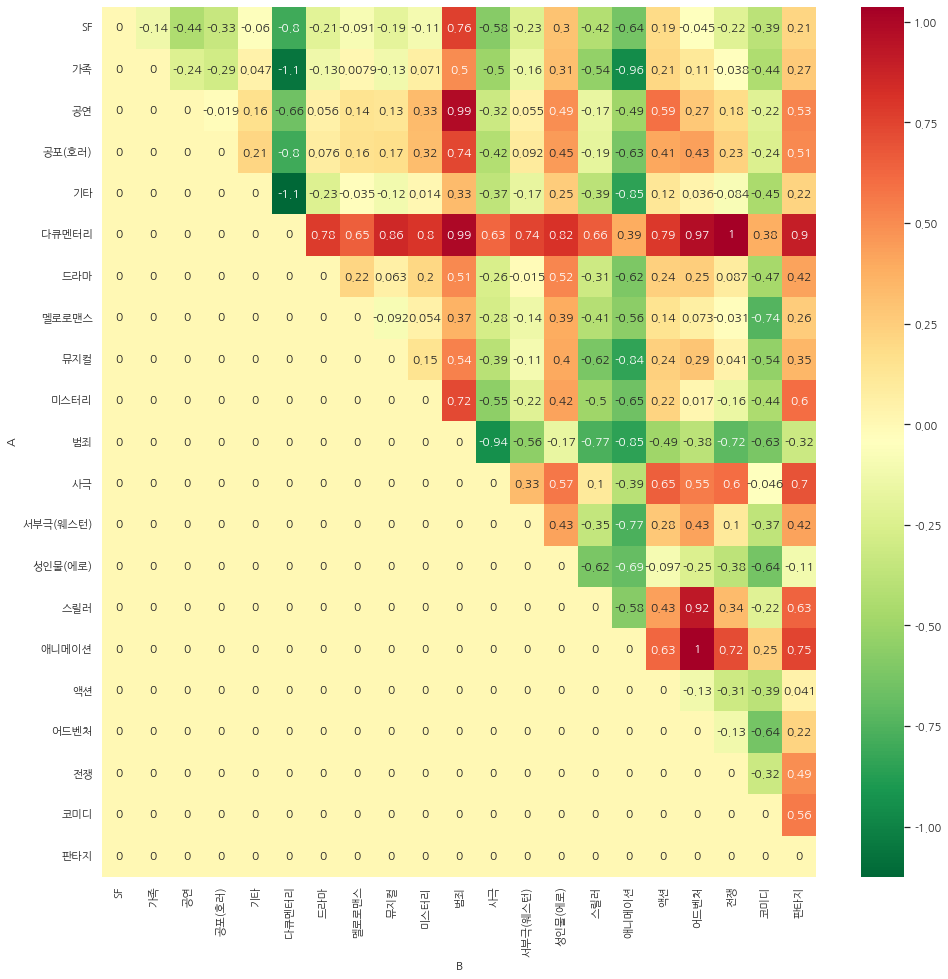

In [49]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

# attribute별 WEAT score 행렬을 히트맵으로 표현
_, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', ax=ax)
ax.set_ylabel('A')
ax.set_xlabel('B')
plt.show()

In [53]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        score = matrix[i][j]
        if score >= 0.8 or score <= -0.8:
            print(f'{genre_name[i]} vs {genre_name[j]}, WEAT score: {score}')
            if score > 0:
                print(f'예술영화-{genre_name[i]}  일반영화-{genre_name[j]}')
            else:
                print(f'예술영화-{genre_name[j]}  일반영화-{genre_name[i]}')
            print('')

SF vs 다큐멘터리, WEAT score: -0.801531195640564
예술영화-다큐멘터리  일반영화-SF

가족 vs 다큐멘터리, WEAT score: -1.0635334253311157
예술영화-다큐멘터리  일반영화-가족

가족 vs 애니메이션, WEAT score: -0.9624679088592529
예술영화-애니메이션  일반영화-가족

공연 vs 범죄, WEAT score: 0.9856438040733337
예술영화-공연  일반영화-범죄

공포(호러) vs 다큐멘터리, WEAT score: -0.8004717826843262
예술영화-다큐멘터리  일반영화-공포(호러)

기타 vs 다큐멘터리, WEAT score: -1.1252416372299194
예술영화-다큐멘터리  일반영화-기타

기타 vs 애니메이션, WEAT score: -0.8493719696998596
예술영화-애니메이션  일반영화-기타

다큐멘터리 vs 뮤지컬, WEAT score: 0.8556143641471863
예술영화-다큐멘터리  일반영화-뮤지컬

다큐멘터리 vs 미스터리, WEAT score: 0.8015859127044678
예술영화-다큐멘터리  일반영화-미스터리

다큐멘터리 vs 범죄, WEAT score: 0.994361937046051
예술영화-다큐멘터리  일반영화-범죄

다큐멘터리 vs 성인물(에로), WEAT score: 0.8160060048103333
예술영화-다큐멘터리  일반영화-성인물(에로)

다큐멘터리 vs 어드벤처, WEAT score: 0.9708645939826965
예술영화-다큐멘터리  일반영화-어드벤처

다큐멘터리 vs 전쟁, WEAT score: 1.0300084352493286
예술영화-다큐멘터리  일반영화-전쟁

다큐멘터리 vs 판타지, WEAT score: 0.8989397883415222
예술영화-다큐멘터리  일반영화-판타지

뮤지컬 vs 애니메이션, WEAT score: -0.840512216091156
예술영화-애니메이션  일반영화-